In [1]:
import numpy as np
from lmfit import Model
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Two-Step Task Simulation

In [2]:
def simulate_RL(params, T, qqw=True, data=False, lik=False, seed=0):
    def softmax(vector, beta, pi, t, c1):
        vector = [x*beta for x in vector]
        if t > 0:
            vector[c1[t-1]] += pi
        e = np.exp(vector)
        return e / e.sum()
    
    # T=T+1
    eta1 = params[0]
    beta = params[1]
    beta2 = params[2]
    w = params[3]
    pi = params[4]
    eligibility = params[5]
    if qqw == True:
        eta2 = params[6]
    
    if data == False:
        c1 = np.zeros((T), dtype = int)
        c2 = np.zeros((T), dtype = int)
        r = np.zeros((T), dtype = int)
        state2 = np.zeros((T), dtype = int)
    else:
        c1 = data[0]
        c2 = data[1]
        r = data[2]
        state2 = data[3]
        T = len(data[0])
    pchoice1 = np.zeros((T), dtype = float)
    pchoice2 = np.zeros((T), dtype = float)
    trial = np.zeros((T), dtype = int)
    Q1 = [0.5, 0.5]
    Q2 = [[0.5, 0.5], [0.5, 0.5]]
    Qmb = [0, 0]; Qhy = [0, 0]
    transition_rate = [0.3, 0.7]
    reward_rates = [[0.7, 0.3], [0.3, 0.7]]

    for t in range(T):

        # store trial number
        trial[t] = t+1
        np.random.seed(t + T*seed)

        Qmb[0] = transition_rate[0] * Q2[0][np.argmax(Q2[0])] + transition_rate[1] * Q2[1][np.argmax(Q2[1])]
        Qmb[1] = transition_rate[1] * Q2[0][np.argmax(Q2[0])] + transition_rate[0] * Q2[1][np.argmax(Q2[1])]
        Qhy[0] = w * Qmb[0] + (1-w) * Q1[0]
        Qhy[1] = w * Qmb[1] + (1-w) * Q1[1]
        
        # compute choice probabilities
        p = softmax(Qhy, beta, pi, t, c1)
        
        if data == False:
            c1[t] = np.random.choice(range(0, 2), 1, p=p)

        pchoice1[t] = p[c1[t]]

        if data == False:
            state2[t] = int(np.random.rand() < transition_rate[c1[t]])

        p2 = softmax(Q2[state2[t]], beta2, pi, 0, c2)

        if data == False:
            c2[t] = np.random.choice(range(0, 2), 1, p=p2)

        pchoice2[t] = p2[c2[t]]
            
        # generate reward based on reward probability
        if data == False:
            r[t] = int(np.random.rand() < reward_rates[state2[t]][c2[t]])
            jitter1 = np.random.normal(0, .05)
            jitter2 = np.random.normal(0, .05)
            reward_rates[0][0] += jitter1; reward_rates[0][1] -= jitter1
            reward_rates[1][0] += jitter2; reward_rates[1][1] -= jitter2
            for rri, rr in enumerate([reward_rates[0], reward_rates[1]]):
                for i, x in enumerate(rr):
                    if x < 0:
                        reward_rates[rri][i] = 0
                    elif x > 1:
                        reward_rates[rri][i] = 1

        # update values
        if qqw == True:
            Q1[c1[t]] += ((eta1 * Q2[state2[t]][c2[t]]) - (eta2 * (Q1[c1[t]]**2)))
            Q1[c1[t]] += (eligibility * ((eta1 * r[t]) - (eta2 * (Q2[state2[t]][c2[t]]**2))))
            Q2[state2[t]][c2[t]] += ((eta1 * r[t]) - (eta2 * (Q2[state2[t]][c2[t]]**2)))
        else:
            Q1[c1[t]] += eta1 * (Q2[state2[t]][c2[t]] - Q1[c1[t]])
            Q1[c1[t]] += (eligibility * eta1 * (r[t] - Q2[state2[t]][c2[t]]))
            Q2[state2[t]][c2[t]] += eta1 * (r[t] - Q2[state2[t]][c2[t]])
        for qval in [Q1, Q2[0], Q2[1]]:
            for i, x in enumerate(qval):
                if x < 0:
                    qval[i] = 0
                elif x > 1:
                    qval[i] = 1

    negLL = -1 * (np.ma.masked_invalid(np.log(pchoice1)).sum() + np.ma.masked_invalid(np.log(pchoice2)).sum())

    if lik == True:
        return negLL
    else:
        return c1, c2, r, state2, negLL

## Simulate Synthetic Data for the Two-Step Task according to the QQW variant

In [7]:
data = []
simpars = []
for sim in range(100):
    np.random.seed(sim)
    eta1 = np.random.beta(1.1, 1.1) * 0.7
    eta2 = np.random.uniform(eta1, 1)
    beta1 = np.random.gamma(1.2, 5)
    beta2 = np.random.gamma(1.2, 5)
    while beta1 > 20:
        beta1 = np.random.gamma(1.2, 5)
    while beta2 > 20:
        beta2 = np.random.gamma(1.2, 5)
    w = np.random.beta(1.1, 1.1)
    p = (np.random.beta(1.1, 1.1) * 10) - 5
    elig = np.random.beta(1.1, 1.1)
    simpars.append([eta1, beta1, beta2, w, p, elig, eta2])
    data.append(simulate_RL([eta1, beta1, beta2, w, p, elig, eta2], 1000, qqw=True, seed=sim))

## Fit the QQW variant to the synthetic QQW Two-Step data

In [8]:
qqwfits = []
qqwpars = []
for s, sim in enumerate(data):
    model = scipy.optimize.minimize(simulate_RL, x0=[0.5, 1, 1, .5, 0, 0.5, 0.5], 
                            bounds=[(0, 0.7), (0, 20), (0, 20), (0, 1), (-5, 5), (0, 1), (0, 1)],
                            args=(1000, True, sim, True, s), options={'maxiter': 10000}, #tol=1e-10,
                            method='L-BFGS-B')
    # model = scipy.optimize.differential_evolution(simulate_RL, 
    #                         bounds=[(0, 1), (0, 2), (0, 2), (0, 1), (-.5, .5), (0, 1), (0, 1)],
    #                         args=(1000, True, sim, True), maxiter=10, popsize=15,
    #                         disp=True, x0=[.5, 1, 1, .5, 0, .5, .5])
    # print('simpars: ', simpars[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    qqwpars.append([float('%.4f' % x) for x in model.x])
    qqwfits.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Fit the original RW variant to the synthetic QQW Two-Step data

In [9]:
rwfits = []
rwpars = []
for s, sim in enumerate(data):
    model = scipy.optimize.minimize(simulate_RL, x0=[0.5, 1, 1, .5, 0, 0.5], 
                            bounds=[(0, 0.7), (0, 20), (0, 20), (0, 1), (-5, 5), (0, 1)],
                            args=(1000, False, sim, True, s), options={'maxiter': 10000},
                            method='L-BFGS-B')
    # model = scipy.optimize.differential_evolution(simulate_RL, 
    #                         bounds=[(0, 1), (0, 2), (0, 2), (0, 1), (-.5, .5), (0, 1)],
    #                         args=(1000, False, sim, True), maxiter=10, popsize=15,
    #                         disp=True, x0=[.5, 1, 1, .5, 0, .5])
    # print('simpars: ', simpars[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    rwpars.append([float('%.4f' % x) for x in model.x])
    rwfits.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Model and parameter recovery for Two-Step models using synthetic QQW data

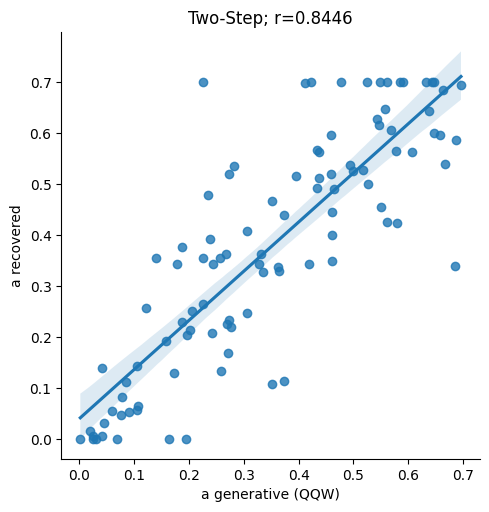

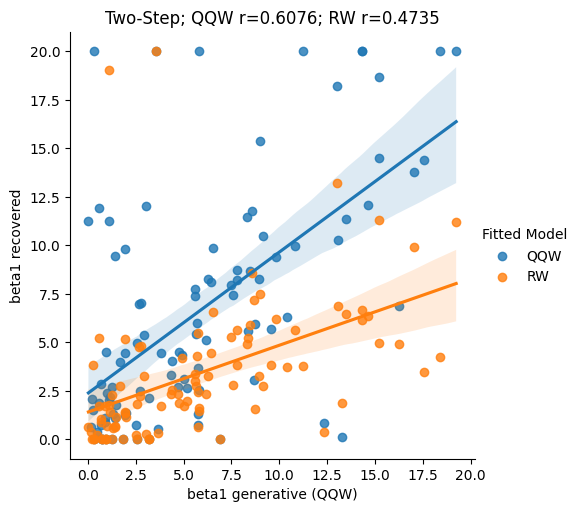

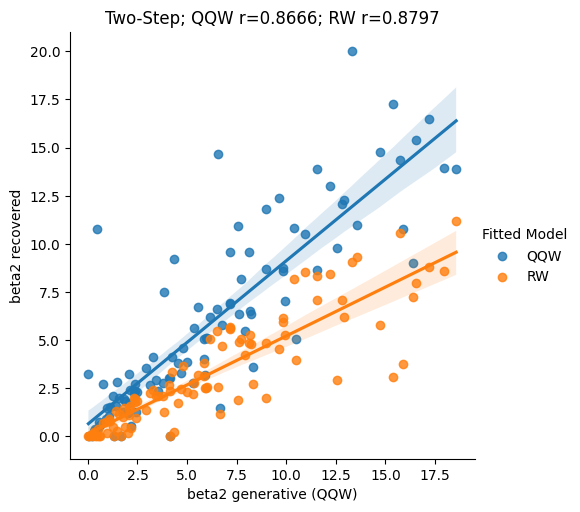

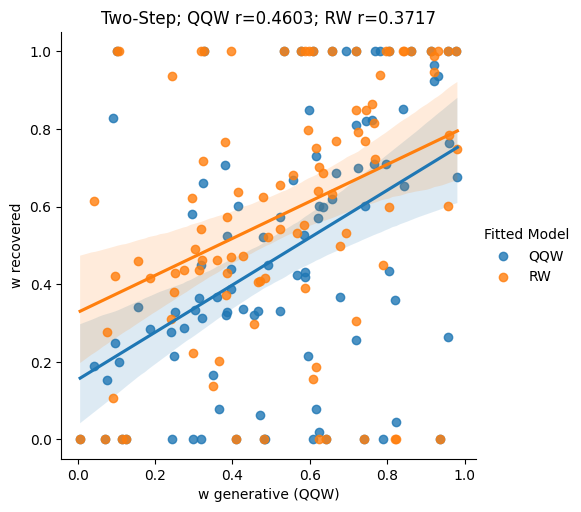

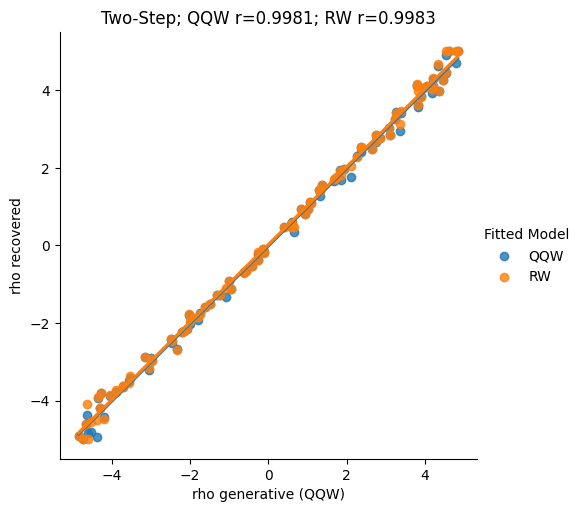

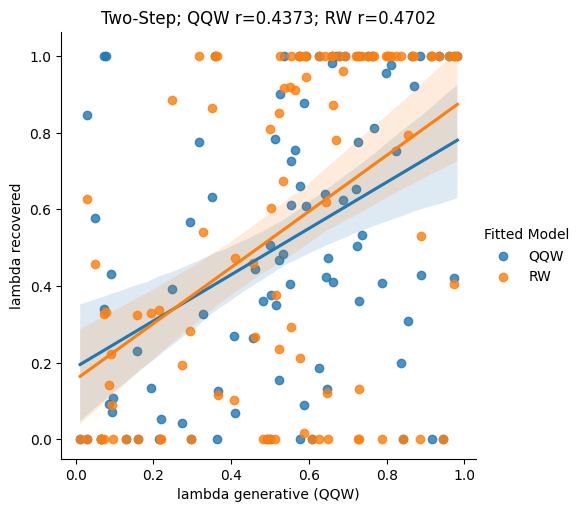

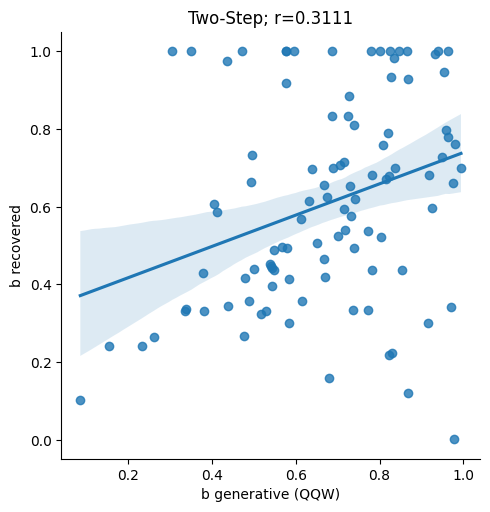

In [10]:
qqwbics = [2*x + 7*np.log(1000) for x in qqwfits]
rwbics = [2*x + 6*np.log(1000) for x in rwfits]
bicdifs = [q - r for q, r in zip(qqwbics,rwbics)]

parnames = ['a', 'beta1', 'beta2', 'w', 'rho', 'lambda', 'b']

for x in range(len(simpars[0])):
    par = parnames[x]
    if par in ['a', 'b']:
        qqwpardf = pd.DataFrame({'%s generative (QQW)' % par: [s[x] for s in simpars], '%s recovered' % par: [s[x] for s in qqwpars]})
        sns.lmplot(data=qqwpardf, x='%s generative (QQW)' % par, y='%s recovered' % par)
        plt.title('Two-Step; r=%.4f' % (scipy.stats.pearsonr(qqwpardf['%s generative (QQW)' % par], qqwpardf['%s recovered' % par])[0],
                                      ))
    else:
        qqwpardf = pd.DataFrame({'%s generative (QQW)' % par: [s[x] for s in simpars] * 2, '%s recovered' % par: [s[x] for s in qqwpars] + [s[x] for s in rwpars],
                                 'Fitted Model': ['QQW']*100 + ['RW']*100})
        sns.lmplot(data=qqwpardf, x='%s generative (QQW)' % par, y='%s recovered' % par, hue='Fitted Model')
        plt.title('Two-Step; QQW r=%.4f; RW r=%.4f' % (scipy.stats.pearsonr(qqwpardf[qqwpardf['Fitted Model']=='QQW']['%s generative (QQW)' % par], qqwpardf[qqwpardf['Fitted Model']=='QQW']['%s recovered' % par])[0],
                                        scipy.stats.pearsonr(qqwpardf[qqwpardf['Fitted Model']=='RW']['%s generative (QQW)' % par], qqwpardf[qqwpardf['Fitted Model']=='RW']['%s recovered' % par])[0]))


## Simulate Synthetic Data for the Two-Step Task according to the original RW variant

In [254]:
data_rw = []
simpars_rw = []
for sim in range(100):
    np.random.seed(sim)
    eta1 = np.random.beta(1.1, 1.1)
    beta1 = np.random.gamma(1.2, 5)
    beta2 = np.random.gamma(1.2, 5)
    while beta1 > 20:
        beta1 = np.random.gamma(1.2, 5)
    while beta2 > 20:
        beta2 = np.random.gamma(1.2, 5)
    w = np.random.beta(1.1, 1.1)
    p = (np.random.beta(1.1, 1.1) * 10) - 5
    elig = np.random.beta(1.1, 1.1)
    simpars_rw.append([eta1, beta1, beta2, w, p, elig])
    data_rw.append(simulate_RL([eta1, beta1, beta2, w, p, elig], 1000, qqw=False, seed=sim))

## Fit the QQW variant to the synthetic RW Two-Step data

In [255]:
qqwfits_rw = []
qqwpars_rw = []
for s, sim in enumerate(data_rw):
    model = scipy.optimize.minimize(simulate_RL, x0=[0.5, 1, 1, .5, 0, .5, 0.5], 
                            bounds=[(0, 1), (0, 20), (0, 20), (0, 1), (-5, 5), (0, 1), (0, 1)],
                            args=(1000, True, sim, True, s), options={'maxiter': 10000},
                            method='L-BFGS-B')
    # print('simpars: ', simpars_rw[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    qqwpars_rw.append([float('%.4f' % x) for x in model.x])
    qqwfits_rw.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Fit the original RW variant to the synthetic RW Two-Step data

In [275]:
rwfits_rw = []
rwpars_rw = []
for s, sim in enumerate(data_rw):
    model = scipy.optimize.minimize(simulate_RL, x0=[0.5, 1, 1, .5, 0, 0.5], 
                            bounds=[(0, 1), (0, 20), (0, 20), (0, 1), (-5, 5), (0, 1)],
                            args=(1000, False, sim, True, s), options={'maxiter': 10000},
                            method='L-BFGS-B')
    # print('simpars: ', simpars_rw[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    rwpars_rw.append([float('%.4f' % x) for x in model.x])
    rwfits_rw.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## Model and parameter recovery for Two-Step models using synthetic RW data

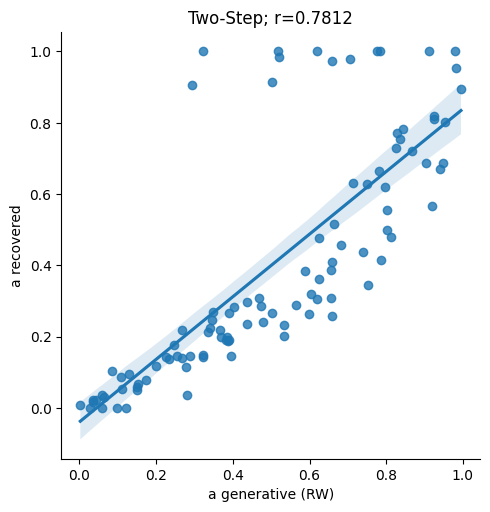

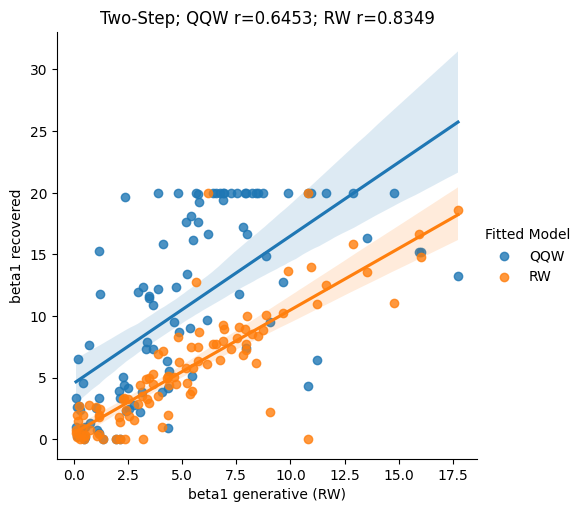

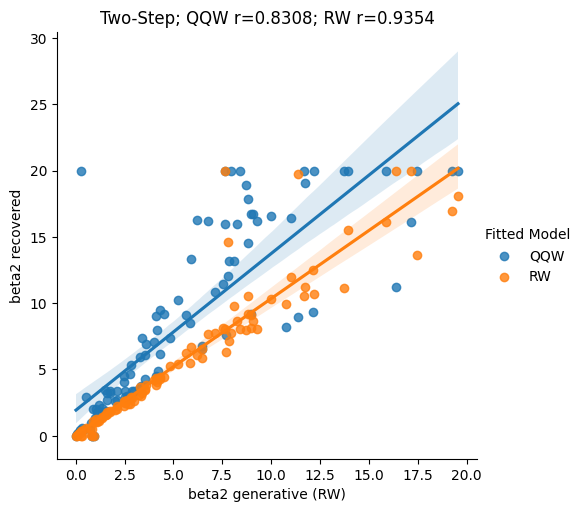

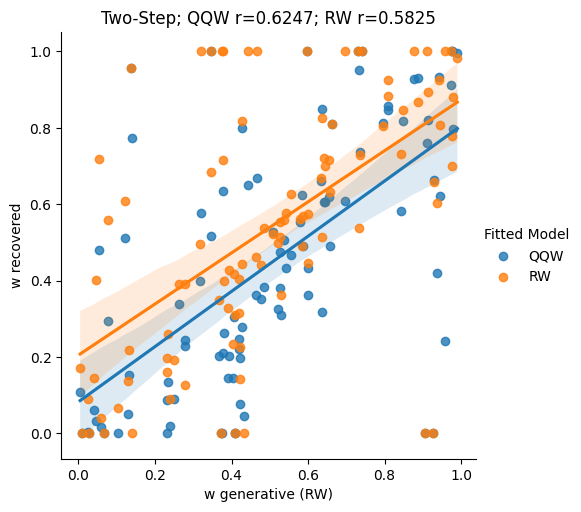

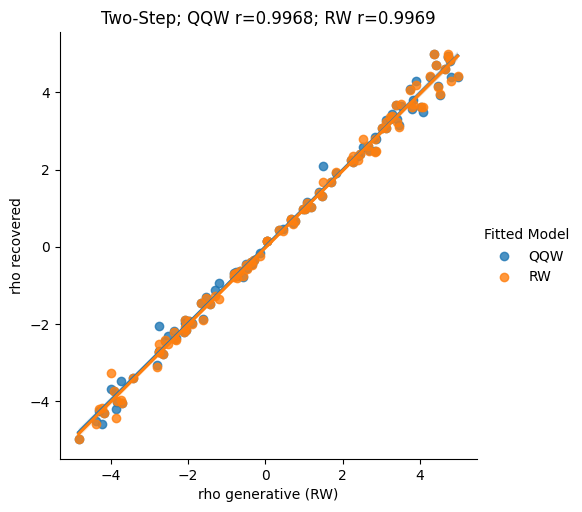

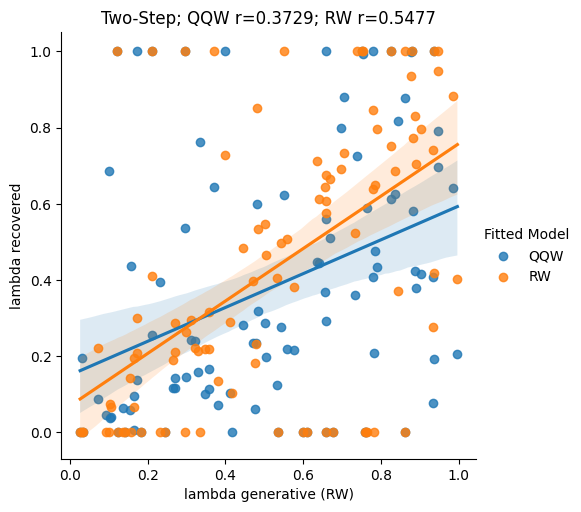

In [365]:
qqwbics_rw = [2*x + 7*np.log(1000) for x in qqwfits_rw]
rwbics_rw = [2*x + 6*np.log(1000) for x in rwfits_rw]
bicdifs_rw = [q - r for q, r in zip(qqwbics_rw,rwbics_rw)]

parnames = ['a', 'beta1', 'beta2', 'w', 'rho', 'lambda']

for x in range(len(simpars_rw[0])):
    par = parnames[x]
    if par in ['a', 'b']:
        qqwpardf_rw = pd.DataFrame({'%s generative (RW)' % par: [s[x] for s in simpars_rw], '%s recovered' % par: [s[x] for s in qqwpars_rw]})
        sns.lmplot(data=qqwpardf_rw, x='%s generative (RW)' % par, y='%s recovered' % par)
        plt.title('Two-Step; r=%.4f' % (scipy.stats.pearsonr(qqwpardf_rw['%s generative (RW)' % par], qqwpardf_rw['%s recovered' % par])[0],
                                      ))
    else:
        qqwpardf_rw = pd.DataFrame({'%s generative (RW)' % par: [s[x] for s in simpars_rw] * 2, '%s recovered' % par: [s[x] for s in qqwpars_rw] + [s[x] for s in rwpars_rw],
                                 'Fitted Model': ['QQW']*100 + ['RW']*100})
        sns.lmplot(data=qqwpardf_rw, x='%s generative (RW)' % par, y='%s recovered' % par, hue='Fitted Model')
        plt.title('Two-Step; QQW r=%.4f; RW r=%.4f' % (scipy.stats.pearsonr(qqwpardf_rw[qqwpardf_rw['Fitted Model']=='QQW']['%s generative (RW)' % par], qqwpardf_rw[qqwpardf_rw['Fitted Model']=='QQW']['%s recovered' % par])[0],
                                        scipy.stats.pearsonr(qqwpardf_rw[qqwpardf_rw['Fitted Model']=='RW']['%s generative (RW)' % par], qqwpardf_rw[qqwpardf_rw['Fitted Model']=='RW']['%s recovered' % par])[0]))


<Axes: xlabel='generative model', ylabel='difBIC'>

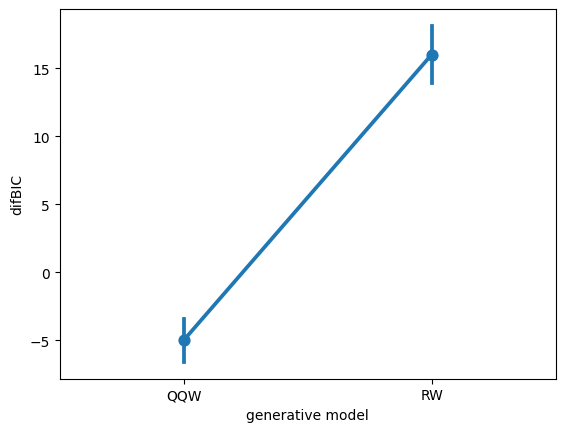

In [353]:
biccomp = pd.DataFrame({'difBIC': bicdifs + bicdifs_rw, 'generative model': ['QQW']*100 + ['RW']*100})
sns.pointplot(data=biccomp, x='generative model', y='difBIC', errorbar='se')
# sns.boxplot(data=biccomp, x='generative model', y='difBIC')


## Confirmation Bias Model Simulation

In [309]:
def simulate_confRL(params, T, qqw=True, data=False, lik=False, seed=0):
    def softmax(vector, vector2, beta, phi):
        pa = 1 / (1 + np.exp(-beta*(vector[0]-vector[1]) - phi*(vector2[0]-vector2[1])))
        return [pa, 1-pa]
    
    # T=T+1
    eta1 = params[0]
    tau1 = params[1]
    beta = params[2]
    phi = params[3]
    if qqw == True:
        eta2 = params[4]
        # tau2 = params[5]

    
    if data == False:
        c1 = np.zeros((T), dtype = int)
        r = np.zeros((T), dtype = int)
    else:
        c1 = data[0]
        r = data[1]
        T = len(data[0])
    pchoice = np.zeros((T), dtype = float)
    rchoice = np.zeros((T), dtype = float)
    trial = np.zeros((T), dtype = int)
    Q1 = [0.5, 0.5]
    C1 = [0.5, 0.5]
    reward_rates = [0.45, 0.55]

    LL = 0
    for t in range(T):

        # store trial number
        trial[t] = t+1
        np.random.seed(t + T*seed)
        
        # compute choice probabilities
        p = softmax(Q1, C1, beta, phi)
        
        if data == False:
            c1[t] = np.random.choice(range(0, 2), 1, p=p)

        LL += np.log(p[c1[t]] + 1e-10)

        pchoice[t] = p[0]
        rchoice[t] = reward_rates[0]
            
        # generate reward based on reward probability
        if data == False:
            r[t] = int(np.random.rand() < reward_rates[c1[t]])
            jitter1 = np.random.normal(0, .05)
            reward_rates[0] += jitter1; reward_rates[1] -= jitter1
            for rri, rr in enumerate([reward_rates[0], reward_rates[1]]):
                if rr < 0:
                    reward_rates[rri] = 0
                elif rr > 1:
                    reward_rates[rri] = 1

        # update values
        if qqw == True:
            Q1[c1[t]] += ((eta1 * r[t]) - (eta2 * (Q1[c1[t]]**2)))
            # C1[c1[t]] += (tau1 - (tau2 * (C1[c1[t]]**2)))
            # C1[1-c1[t]] -= (tau2 * (C1[1-c1[t]]**2))
            C1[c1[t]] += (tau1 * (1 - C1[c1[t]]))
            C1[1-c1[t]] -= (tau1 * C1[1-c1[t]])
        else:
            Q1[c1[t]] += (eta1 * (r[t] - Q1[c1[t]]))
            C1[c1[t]] += (tau1 * (1 - C1[c1[t]]))
            C1[1-c1[t]] -= (tau1 * C1[1-c1[t]])
        for val in [Q1, C1]:
            for i, x in enumerate(val):
                if x < 0:
                    val[i] = 0
                elif x > 1:
                    val[i] = 1

    negLL = -1 * LL
    #(np.ma.masked_invalid(np.log(pchoice1 + 1e-10)).sum())

    if lik == True:
        return negLL
    else:
        return c1, r, negLL, pchoice, rchoice

In [310]:
cb_data = []
cb_simpars = []
for sim in range(100):
    np.random.seed(sim)
    eta1 = np.random.beta(1.1, 1.1)*0.7
    eta2 = np.random.uniform(eta1, 1)
    tau1 = np.random.beta(1.1, 1.1)
    # tau2 = np.random.uniform(tau1, 1)
    beta = np.random.gamma(1.2, 5)
    phi = np.random.beta(1.1, 1.1)*10 - 5
    while beta > 20:
        beta = np.random.gamma(1.2, 5)
    cb_simpars.append([eta1, tau1, beta, phi, eta2])
    cb_data.append(simulate_confRL([eta1, tau1, beta, phi, eta2], 1000, qqw=True, seed=sim))
    

In [311]:
cb_qqwfits = []
cb_qqwpars = []
for s, sim in enumerate(cb_data):
    model = scipy.optimize.minimize(simulate_confRL, x0=[0.5, 0.5, 1, 0, 0.5], 
                            bounds=[(0, 1), (0, 1), (0, 20), (-5, 5), (0, 1)],
                            args=(1000, True, sim, True, s), options={'maxiter': 10000}, #tol=1e-10,
                            method='L-BFGS-B')
    # print('simpars: ', cb_simpars[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    cb_qqwpars.append([float('%.4f' % x) for x in model.x])
    cb_qqwfits.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [312]:
cb_rwfits = []
cb_rwpars = []
for s, sim in enumerate(cb_data):
    model = scipy.optimize.minimize(simulate_confRL, x0=[0.5, 0.5, 1, 0], 
                            bounds=[(0, 1), (0, 1), (0, 20), (-5, 5)],
                            args=(1000, False, sim, True, s), options={'maxiter': 10000}, #tol=1e-10,
                            method='L-BFGS-B')
    # print('simpars: ', cb_simpars[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    cb_rwpars.append([float('%.4f' % x) for x in model.x])
    cb_rwfits.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


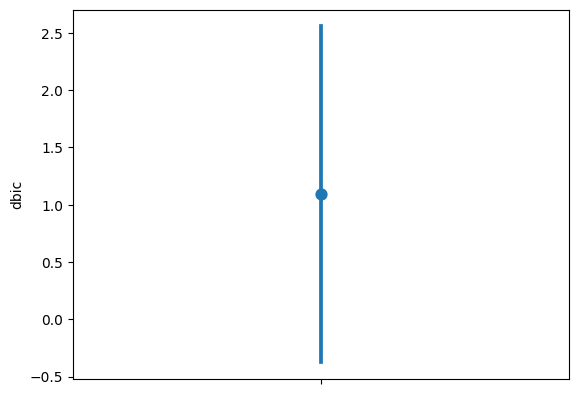

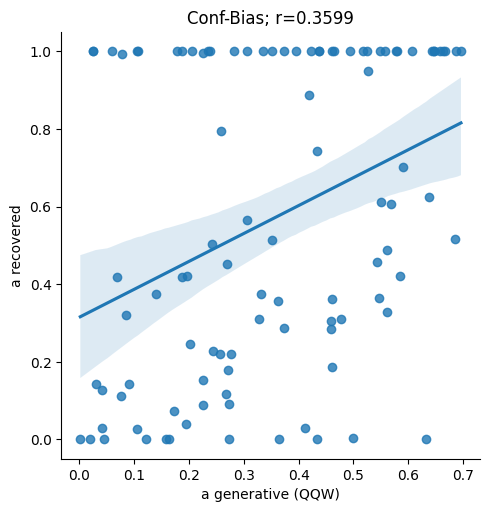

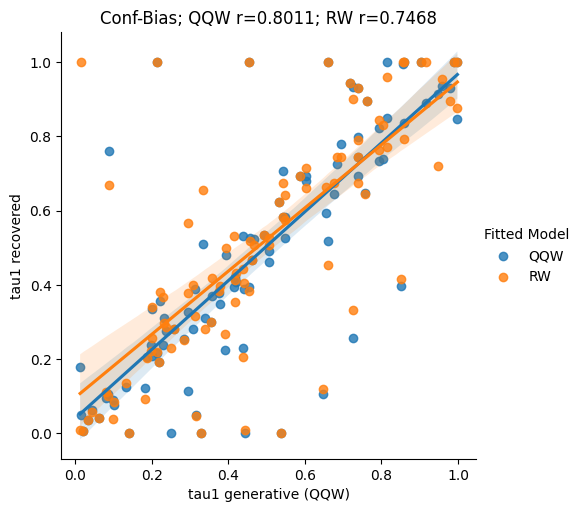

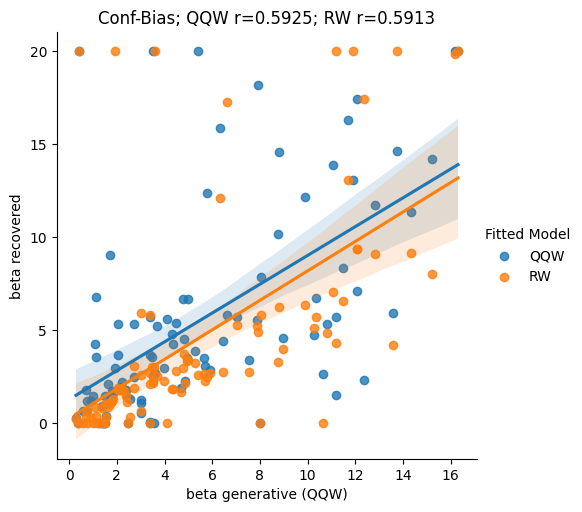

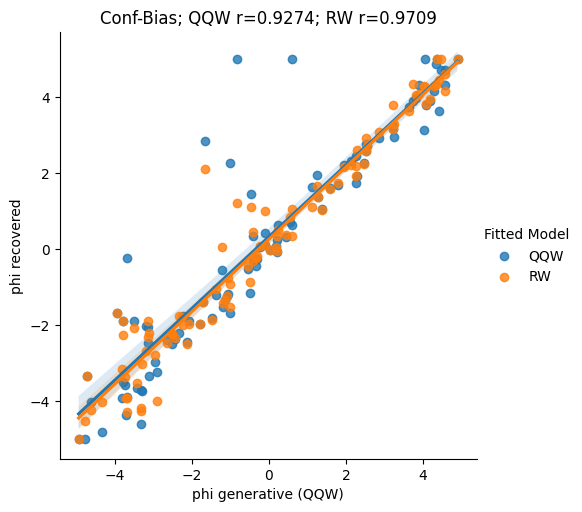

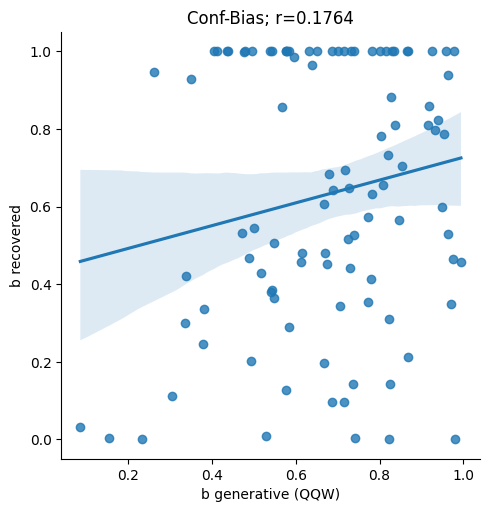

In [366]:
cb_qqwbics = [2*x + 5*np.log(1000) for x in cb_qqwfits]
cb_rwbics = [2*x + 4*np.log(1000) for x in cb_rwfits]
cb_bicdifs = [q - r for q, r in zip(cb_qqwbics,cb_rwbics)]

parnames = ['a', 'tau1', 'beta', 'phi', 'b']

sns.pointplot(data=pd.DataFrame({'dbic': cb_bicdifs}), y='dbic', errorbar='se')

for x in range(len(cb_simpars[0])):
    par = parnames[x]
    if par in ['a', 'b']:
        cb_qqwpardf = pd.DataFrame({'%s generative (QQW)' % par: [s[x] for s in cb_simpars], '%s recovered' % par: [s[x] for s in cb_qqwpars]})
        sns.lmplot(data=cb_qqwpardf, x='%s generative (QQW)' % par, y='%s recovered' % par)
        plt.title('Conf-Bias; r=%.4f' % (scipy.stats.pearsonr(cb_qqwpardf['%s generative (QQW)' % par], cb_qqwpardf['%s recovered' % par])[0],
                                      ))
    else:
        cb_qqwpardf = pd.DataFrame({'%s generative (QQW)' % par: [s[x] for s in cb_simpars] * 2, '%s recovered' % par: [s[x] for s in cb_qqwpars] + [s[x] for s in cb_rwpars],
                                 'Fitted Model': ['QQW']*100 + ['RW']*100})
        sns.lmplot(data=cb_qqwpardf, x='%s generative (QQW)' % par, y='%s recovered' % par, hue='Fitted Model')
        plt.title('Conf-Bias; QQW r=%.4f; RW r=%.4f' % (scipy.stats.pearsonr(cb_qqwpardf[cb_qqwpardf['Fitted Model']=='QQW']['%s generative (QQW)' % par], cb_qqwpardf[cb_qqwpardf['Fitted Model']=='QQW']['%s recovered' % par])[0],
                                        scipy.stats.pearsonr(cb_qqwpardf[cb_qqwpardf['Fitted Model']=='RW']['%s generative (QQW)' % par], cb_qqwpardf[cb_qqwpardf['Fitted Model']=='RW']['%s recovered' % par])[0]))

In [314]:
cb_data_rw = []
cb_simpars_rw = []
for sim in range(100):
    np.random.seed(sim)
    eta1 = np.random.beta(1.1, 1.1)
    tau1 = np.random.beta(1.1, 1.1)
    beta = np.random.gamma(1.2, 5)
    phi = np.random.beta(1.1, 1.1)*10 - 5
    while beta > 20:
        beta = np.random.gamma(1.2, 5)
    cb_simpars_rw.append([eta1, tau1, beta, phi])
    cb_data_rw.append(simulate_confRL([eta1, tau1, beta, phi], 1000, qqw=False, seed=sim))

In [356]:
cb_qqwfits_rw = []
cb_qqwpars_rw = []
for s, sim in enumerate(cb_data_rw):
    model = scipy.optimize.minimize(simulate_confRL, x0=[0.5, 0.5, 1, 0, 0.5], 
                            bounds=[(0, 1), (0, 1), (0, 20), (-5, 5), (0, 1)],
                            args=(1000, True, sim, True, s), options={'maxiter': 10000}, #tol=1e-10,
                            method='L-BFGS-B')
    # print('simpars: ', cb_simpars[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    cb_qqwpars_rw.append([float('%.4f' % x) for x in model.x])
    cb_qqwfits_rw.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [316]:
cb_rwfits_rw = []
cb_rwpars_rw = []
for s, sim in enumerate(cb_data_rw):
    model = scipy.optimize.minimize(simulate_confRL, x0=[0.5, 0.5, 1, 0], 
                            bounds=[(0, 1), (0, 1), (0, 20), (-5, 5)],
                            args=(1000, False, sim, True, s), options={'maxiter': 10000}, #tol=1e-10,
                            method='L-BFGS-B')
    # print('simpars: ', cb_simpars[s])
    # print('fitpars: ', [float('%.4f' % x) for x in model.x])
    # print(model.fun)
    print(s)
    cb_rwpars_rw.append([float('%.4f' % x) for x in model.x])
    cb_rwfits_rw.append(model.fun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


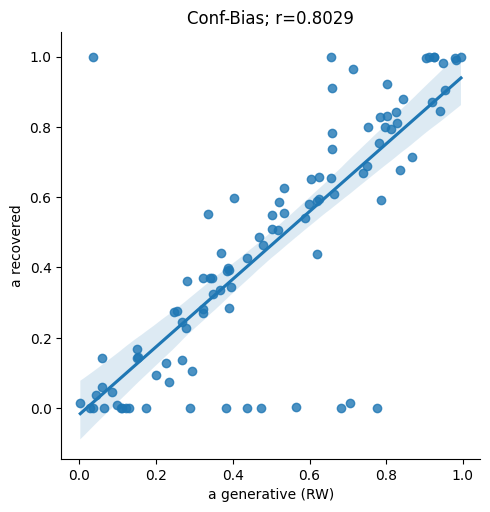

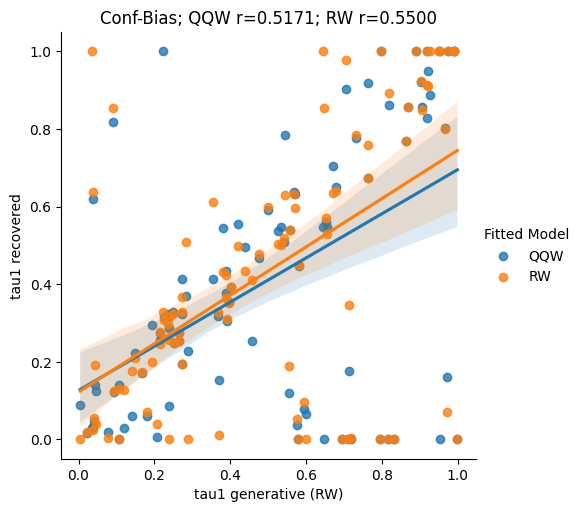

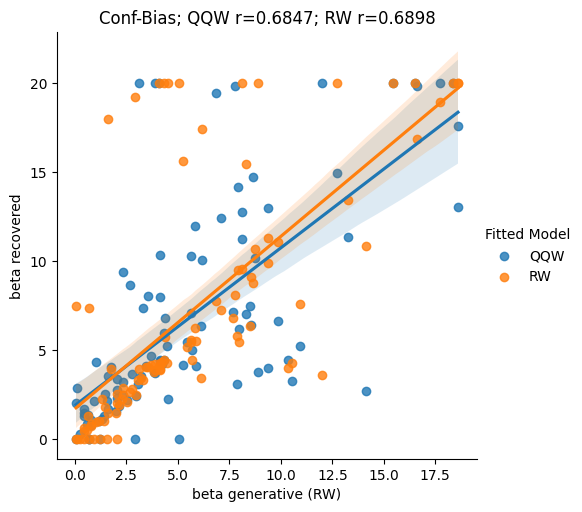

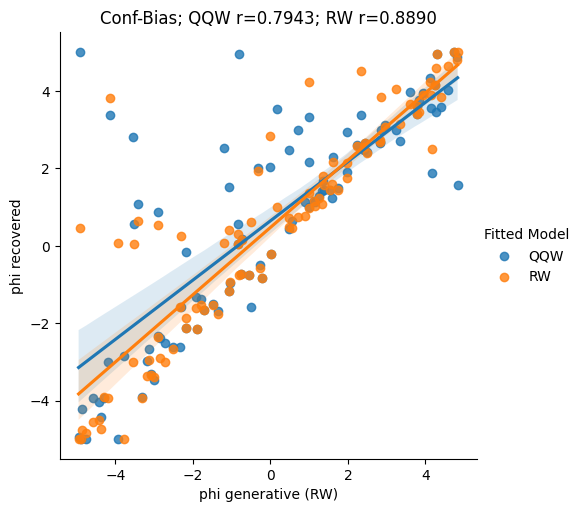

In [367]:
cb_qqwbics_rw = [2*x + 5*np.log(1000) for x in cb_qqwfits_rw]
cb_rwbics_rw = [2*x + 4*np.log(1000) for x in cb_rwfits_rw]
cb_bicdifs_rw = [q - r for q, r in zip(cb_qqwbics_rw,cb_rwbics_rw)]

parnames = ['a', 'tau1', 'beta', 'phi']

for x in range(len(cb_simpars_rw[0])):
    par = parnames[x]
    if par in ['a']:
        cb_qqwpardf_rw = pd.DataFrame({'%s generative (RW)' % par: [s[x] for s in cb_simpars_rw], '%s recovered' % par: [s[x] for s in cb_rwpars_rw]})
        sns.lmplot(data=cb_qqwpardf_rw, x='%s generative (RW)' % par, y='%s recovered' % par)
        plt.title('Conf-Bias; r=%.4f' % (scipy.stats.pearsonr(cb_qqwpardf_rw['%s generative (RW)' % par], cb_qqwpardf_rw['%s recovered' % par])[0],
                                      ))
    else:
        cb_qqwpardf_rw = pd.DataFrame({'%s generative (RW)' % par: [s[x] for s in cb_simpars_rw] * 2, '%s recovered' % par: [s[x] for s in cb_qqwpars_rw] + [s[x] for s in cb_rwpars_rw],
                                 'Fitted Model': ['QQW']*100 + ['RW']*100})
        sns.lmplot(data=cb_qqwpardf_rw, x='%s generative (RW)' % par, y='%s recovered' % par, hue='Fitted Model')
        plt.title('Conf-Bias; QQW r=%.4f; RW r=%.4f' % (scipy.stats.pearsonr(cb_qqwpardf_rw[cb_qqwpardf_rw['Fitted Model']=='QQW']['%s generative (RW)' % par], cb_qqwpardf_rw[cb_qqwpardf_rw['Fitted Model']=='QQW']['%s recovered' % par])[0],
                                        scipy.stats.pearsonr(cb_qqwpardf_rw[cb_qqwpardf_rw['Fitted Model']=='RW']['%s generative (RW)' % par], cb_qqwpardf_rw[cb_qqwpardf_rw['Fitted Model']=='RW']['%s recovered' % par])[0]))

<Axes: xlabel='generative model', ylabel='difBIC'>

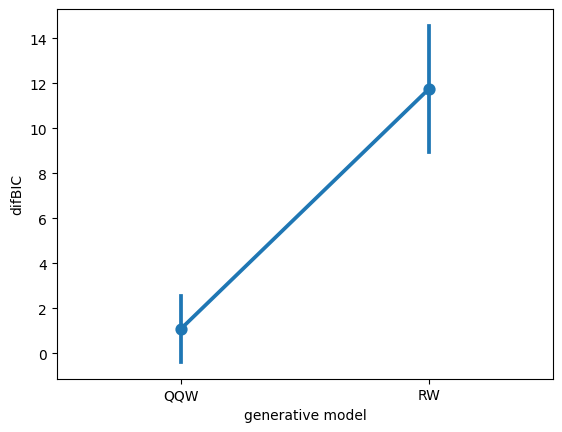

In [358]:
biccomp = pd.DataFrame({'difBIC': cb_bicdifs + cb_bicdifs_rw, 'generative model': ['QQW']*100 + ['RW']*100})
sns.pointplot(data=biccomp, x='generative model', y='difBIC', errorbar='se')
# sns.boxplot(data=biccomp, x='generative model', y='difBIC')

<Axes: xlabel='Synthetic Data', ylabel='QQW BIC - RW BIC'>

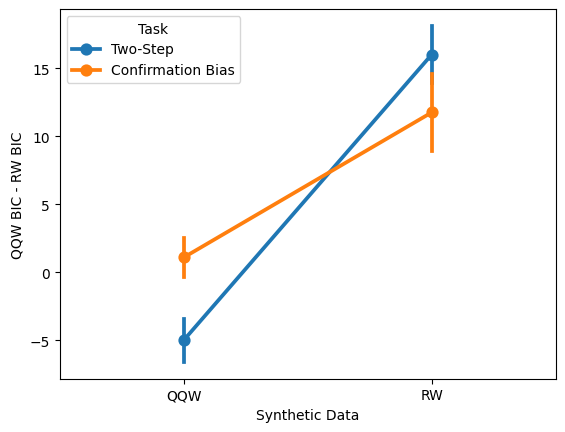

In [359]:
biccomp = pd.DataFrame({'QQW BIC - RW BIC': bicdifs + bicdifs_rw + cb_bicdifs + cb_bicdifs_rw, 
                        'Synthetic Data': ['QQW']*100 + ['RW']*100 + ['QQW']*100 + ['RW']*100,
                        'Task': ['Two-Step']*200 + ['Confirmation Bias']*200})
sns.pointplot(data=biccomp, x='Synthetic Data', y='QQW BIC - RW BIC', hue='Task', errorbar='se')
# sns.boxplot(data=biccomp, x='generative model', y='difBIC')

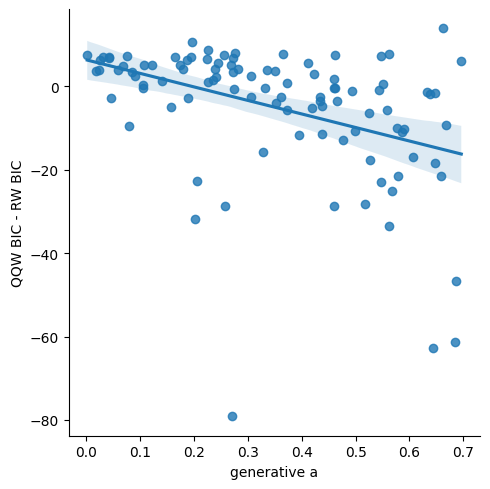

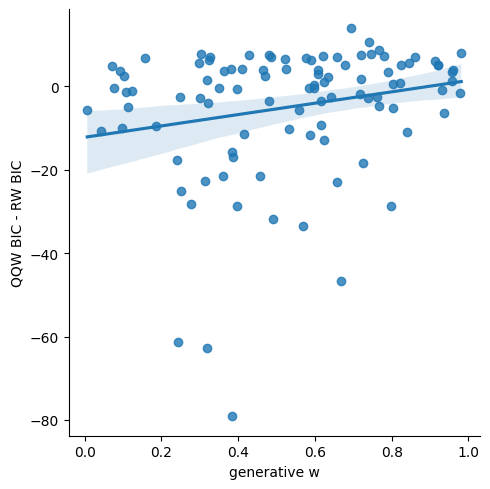

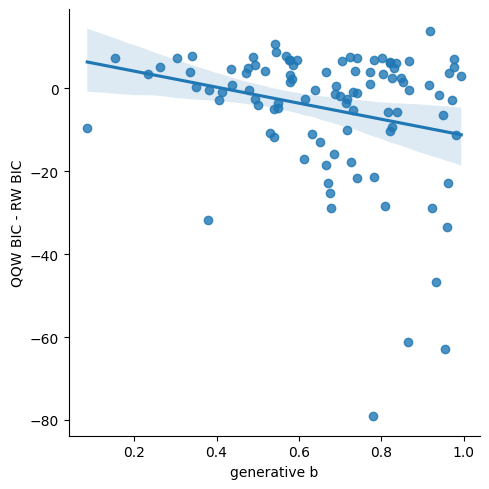

two-step a predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.40677710319533245, pvalue=2.6722984109429638e-05)
two-step beta1 predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.20230124387634876, pvalue=0.04353921980131787)
two-step beta2 predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.07727249927544667, pvalue=0.4447757866956493)
two-step w predicting QQW BIC - RW BIC PearsonRResult(statistic=0.22015930866608785, pvalue=0.027736439467665006)
two-step p predicting QQW BIC - RW BIC PearsonRResult(statistic=0.07938056399725232, pvalue=0.4324151741814745)
two-step lambda predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.08834285418033867, pvalue=0.3821007066737401)
two-step b predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.24633068738129568, pvalue=0.01349121973093376)


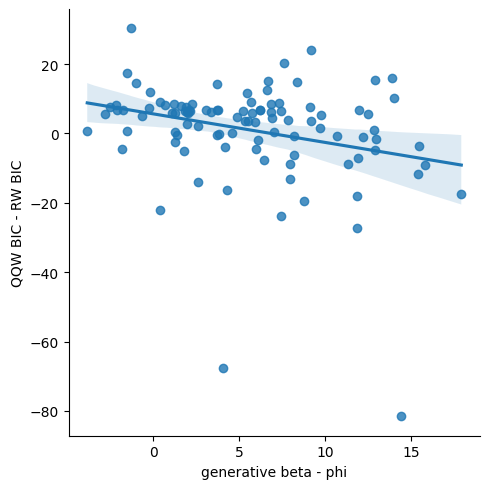

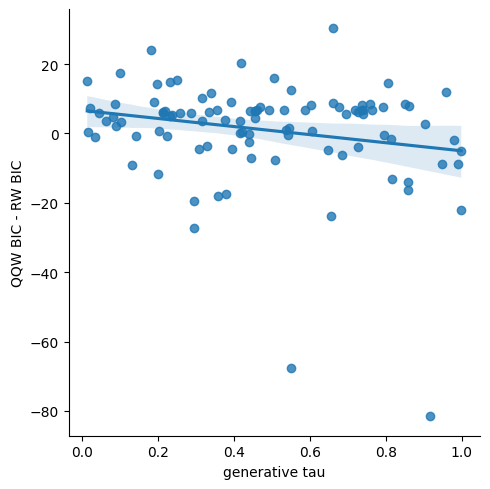

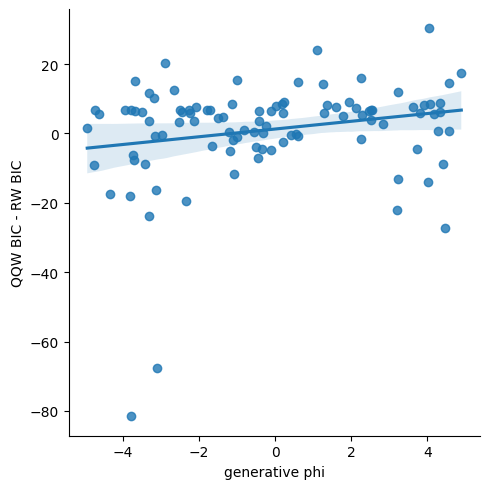

conf bias beta - phi predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.28023832394656323, pvalue=0.0047433023781079916)
conf bias a predicting QQW BIC - RW BIC PearsonRResult(statistic=0.0009783529139473337, pvalue=0.9922921347041288)
conf bias tau predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.21739195922676738, pvalue=0.02980724519419854)
conf bias beta predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.18643192211593065, pvalue=0.06328298205564716)
conf bias phi predicting QQW BIC - RW BIC PearsonRResult(statistic=0.21517709288434514, pvalue=0.03155756740604935)
conf bias b predicting QQW BIC - RW BIC PearsonRResult(statistic=-0.034539458475314824, pvalue=0.7329876979939317)


In [362]:
sns.lmplot(data=pd.DataFrame({'generative a': [x[0] for x in simpars], 
                              'QQW BIC - RW BIC': bicdifs}), x='generative a',
                              y='QQW BIC - RW BIC')
plt.show()

sns.lmplot(data=pd.DataFrame({'generative w': [x[3] for x in simpars], 
                              'QQW BIC - RW BIC': bicdifs}), x='generative w',
                              y='QQW BIC - RW BIC')
plt.show()

sns.lmplot(data=pd.DataFrame({'generative b': [x[6] for x in simpars], 
                              'QQW BIC - RW BIC': bicdifs}), x='generative b',
                              y='QQW BIC - RW BIC')
plt.show()
print('two-step a predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[0] for x in simpars], bicdifs))
print('two-step beta1 predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[1] for x in simpars], bicdifs))
print('two-step beta2 predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[2] for x in simpars], bicdifs))
print('two-step w predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[3] for x in simpars], bicdifs))
print('two-step p predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[4] for x in simpars], bicdifs))
print('two-step lambda predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[5] for x in simpars], bicdifs))
print('two-step b predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[6] for x in simpars], bicdifs))

sns.lmplot(data=pd.DataFrame({'generative beta - phi': [x[2] - x[3] for x in cb_simpars], 
                              'QQW BIC - RW BIC': cb_bicdifs}), x='generative beta - phi',
                              y='QQW BIC - RW BIC')
plt.show()

sns.lmplot(data=pd.DataFrame({'generative tau': [x[1] for x in cb_simpars], 
                              'QQW BIC - RW BIC': cb_bicdifs}), x='generative tau',
                              y='QQW BIC - RW BIC')
plt.show()

sns.lmplot(data=pd.DataFrame({'generative phi': [x[3] for x in cb_simpars], 
                              'QQW BIC - RW BIC': cb_bicdifs}), x='generative phi',
                              y='QQW BIC - RW BIC')
plt.show()

print('conf bias beta - phi predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[2] - x[3] for x in cb_simpars], cb_bicdifs))
print('conf bias a predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[0] for x in cb_simpars], cb_bicdifs))
print('conf bias tau predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[1] for x in cb_simpars], cb_bicdifs))
print('conf bias beta predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[2] for x in cb_simpars], cb_bicdifs))
print('conf bias phi predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[3] for x in cb_simpars], cb_bicdifs))
print('conf bias b predicting QQW BIC - RW BIC', scipy.stats.pearsonr([x[4] for x in cb_simpars], cb_bicdifs))